In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
println("")

In [4]:
t_max = 0.1
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [16]:
function evolutionOperatorExp2(
    Ham::Array, t::AbstractFloat, n::Integer
)::Array
    # c = ones(size(Ham))
    c = one(Ham)
    Len = size(Ham, 1)
    Ham_det = abs(det(Ham))
    Ham_scaled = Ham / Ham_det^(1.0/Len)
    s = c 
    if n > 0
        for k in 1:n
            c = c * (-1.0im/k * Ham_scaled * t)
            s = s + c * Ham_det^(float(k)/Len)
            println(abs(det(c)), abs(det(s)))
            # s[:, :] = s + (-1.0im * Ham * t)^k/factorial(big(k))
        end
    end
    println(abs(det(s)))
    s /= abs(det(s))^(1.0/Len)
    s
end

function evolutionOperatorExp2(
    Ham::T, t::AbstractFloat, n::Integer
) where {B<:Basis,T<:Operator{B,B}}
    data = evolutionOperatorExp2(Ham.data, t, n)
    DenseOperator(Ham.basis_l, Ham.basis_r, data)
end

evolutionOperatorExp2 (generic function with 2 methods)

In [17]:
using OpenQuantumSystems
U_op_n = evolutionOperatorExp2(Ham, 0.01, 50)
println(det(U_op_n.data))
U_op = evolutionOperator(Ham, 1.)
D(U_op_n, U_op), D(U_op_n, zero(U_op_n)), D(U_op, zero(U_op)), D(U_op_n * W0 * U_op_n', U_op * W0 * U_op')

1.000000000000018e-541.1366629811361546e65
7.450580596924085e-1179.622227247313484e121
9.7704876392868e-1841.4331034579660003e174
5.42371016947594e-2549.031411232316461e222
0.01.3755784897414234e269
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
0.0NaN
NaN
NaN + NaN*im


(NaN, NaN, 13.499999999996069, NaN)

In [23]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t = QME_sI_ansatz_linear(
    W0,
    tspan,
    agg;
    reltol = 1e-6,
    abstol = 1e-6,
    int_reltol = 1e-7,
    int_abstol = 1e-7,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

 14.655862 seconds (19.51 M allocations: 3.028 GiB, 3.18% gc time)


([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  0.0955, 0.096, 0.0965, 0.097, 0.0975, 0.098, 0.0985, 0.099, 0.0995, 0.1], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839-0.0im          0.0999399-9.03662e-11im
 0.0+0.0im  0.0999399+9.03662e-11im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839+0.0im          0.0999399-7.20273e-10im
 0.0+0.0im  0.0999399+7.20273e-10im    0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999399-2.38021e-9im
 0.0+0.0im  0.0999

In [24]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 4.206977145958383e-14
3 1.587100443496363e-14
4 6.269124802390077e-11
5 2.2146464351280085e-10
6 3.552423056315174e-10
7 4.0407683209856854e-10
8 3.587026959502309e-10
9 2.482265583138915e-10
10 1.4583165903172701e-10
11 1.6561849081826664e-10
12 2.2375371740638117e-10
13 2.231560706441967e-10
14 1.5452670624071882e-10
15 5.847563232822101e-11
16 4.081545754186588e-11
17 1.3858855576774114e-9
18 3.935386238225822e-9
19 6.923856284303184e-9
20 9.774750904837428e-9
21 1.2080085037228035e-8
22 1.358331587970579e-8
23 1.4161343827092555e-8
24 1.3806132917559464e-8
25 1.260712508257435e-8
26 1.073708684103974e-8
27 8.449458063125422e-9
28 6.113819063370296e-9
29 4.363591441685683e-9
30 4.094046441790428e-9
31 5.110136966216504e-9
32 6.313082766431519e-9
33 7.113777294363704e-9
34 7.3044509585474536e-9
35 6.8543228435452525e-9
36 5.851736570260059e-9
37 4.490528299975542e-9
38 3.067513517834258e-9
39 1.982012600864033e-9
40 1.7920580392314316e-9
41 3.8446823322177e-9
42 7.79371206135

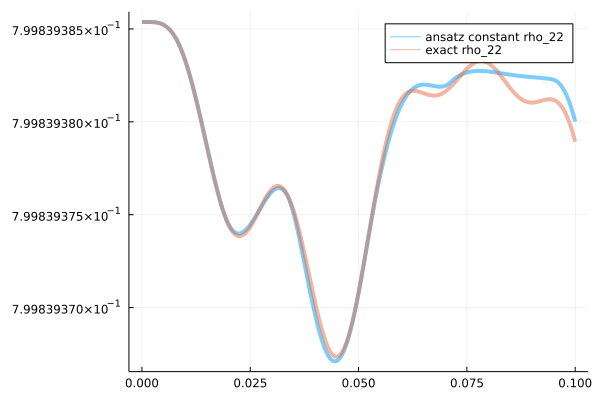

In [25]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

(27, 27)
1 0.0
2 4.2059194973661215e-14
3 1.5879048198861808e-14
4 6.269126053898963e-11
5 2.2146466507285313e-10
6 3.5524229781959954e-10
7 4.0407687889784927e-10
8 3.5870265666851253e-10
9 2.482265713547481e-10
10 1.458316212733966e-10
11 1.656184279350096e-10
12 2.2375364959555358e-10
13 2.2315620608237512e-10
14 1.545267622060131e-10
15 5.847563122967192e-11
16 4.0815481267786815e-11
17 1.3858854484941502e-9
18 3.935386187928156e-9
19 6.923856460503587e-9
20 9.774750802372633e-9
21 1.2080085047051974e-8
22 1.3583315913498328e-8
23 1.4161343787625663e-8
24 1.3806132944868967e-8
25 1.2607125111387071e-8
26 1.0737086866431333e-8
27 8.449458068858166e-9
28 6.1138190509777246e-9
29 4.363591488987323e-9
30 4.094046489502594e-9
31 5.1101369752803664e-9
32 6.3130827939394345e-9
33 7.1137773130719635e-9
34 7.3044508514296884e-9
35 6.854322838600978e-9
36 5.851736549374464e-9
37 4.49052825920569e-9
38 3.0675135923651356e-9
39 1.982012629584584e-9
40 1.7920579530716499e-9
41 3.844682384650513

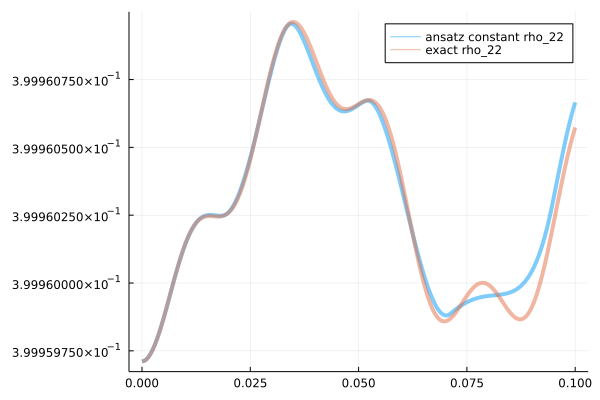

In [26]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
println(size(Ham_0_Sinv))
for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham_sys, t)
    rho_t[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t[t_i].data * U_op.data * Ham_sys_S
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_t_exact[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho * U_op.data * Ham_sys_S
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [27]:
using OpenQuantumSystems
include("test_master_ansatz.jl")


Test Summary: |
master ansatz | No tests


Test.DefaultTestSet("master ansatz", Any[], 0, false, false)

In [71]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
